# Requirement dan Kebutuhan Proyek "ASING!"

*   Tujuan: Deteksi Gambar untuk menghasilkan output jenis/nama makanan serta mengklasifikasikan makanan ke dalam kategori "direkomendasikan" atau "tidak direkomendasikan" untuk ibu hamil.
*  Arsitektur Model: Convolutional Neural Network (CNN) or R-CNN.
*  Framework: TensorFlow.

## Import Library Yang Dibutuhkan

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
import shutil
import matplotlib.pyplot as plt

## Load/Gathering Dataset

*   Dataset di-load dari roboflow, untuk kedepannya kita diskusin dengan team CC
*   Download dan Ekstrak dataset
*   Struktur Folder Dataset harus memiliki struktur sebagai berikut:
```
dataset/
├── train/
│   ├── category1/
│   ├── category2/
│   └── ...
└── validation/
    ├── category1/
    ├── category2/
    └── ...
```

### Download atau Ekstrak Dataset

In [ ]:
!wget -O dataset.zip "https://storage.googleapis.com/dataset-dragon-frost/New_Asing_Classification.zip"
!unzip dataset.zip -d /content/dataset

--2024-06-15 04:21:32--  https://storage.googleapis.com/dataset-dragon-frost/New_Asing_Classification.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.207, 74.125.139.207, 74.125.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.134.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 355650093 (339M) [application/x-zip-compressed]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 339.17M  50.5MB/s    in 7.6s    

2024-06-15 04:21:40 (44.8 MB/s) - ‘dataset.zip’ saved [355650093/355650093]

Archive:  dataset.zip
   creating: /content/dataset/test/apel/
  inflating: /content/dataset/test/apel/Image_20_jpg.rf.cd425efce1803ef98179bfef84e7c023.jpg  
  inflating: /content/dataset/test/apel/Image_32_jpg.rf.afb983d99f9130e8442aee73829bf550.jpg  
  inflating: /content/dataset/test/apel/Image_33_jpg.rf.3a4e16287bc3d9d8550cb8966228baeb.jpg  
  inflating: /content/dataset/test/apel/Image_44_j

### Konfigurasi Direktori Dataset dan Pengaturan Ukuran Gambar

In [ ]:
# Direktori dataset
base_dir = '/content/dataset'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
# test_dir = os.path.join(base_dir, 'test')

# Ukuran gambar sesuai MobileNetV2
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

### Informasi Jumlah Kelas dan Daftar Kelas pada Train dan Valid

In [ ]:
# Print jumlah kelas yang ada di train
train_classes = [dir for dir in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, dir))]
print("\nJumlah class di train:", len(train_classes))
print("List class di train:", train_classes)

# Print jumlah kelas yang ada di valid
valid_classes = [dir for dir in os.listdir(valid_dir) if os.path.isdir(os.path.join(valid_dir, dir))]
print("\nJumlah class di valid:", len(valid_classes))
print("List class di valid:", valid_classes)


Jumlah class di train: 20
List class di train: ['ayam_goreng', 'bakso', 'rendang', 'risoles', 'salak', 'soto_ayam', 'tempe_goreng', 'sate_ayam', 'cabai', 'wortel', 'sawi', 'bayam', 'nasi_uduk', 'mangga', 'pisang', 'jeruk', 'kubis', 'apel', 'tahu', 'nasi_goreng']

Jumlah class di valid: 20
List class di valid: ['ayam_goreng', 'bakso', 'rendang', 'risoles', 'salak', 'soto_ayam', 'tempe_goreng', 'sate_ayam', 'cabai', 'wortel', 'sawi', 'bayam', 'nasi_uduk', 'mangga', 'pisang', 'jeruk', 'kubis', 'apel', 'tahu', 'nasi_goreng']


### Migrasi Data pada Direktori Test ke dalam Direktori Validasi

In [ ]:
def move_images_from_test_to_validation(base_dir):
    test_dir = os.path.join(base_dir, 'test')
    valid_dir = os.path.join(base_dir, 'valid')

    for category in os.listdir(test_dir):
        test_category_dir = os.path.join(test_dir, category)
        if os.path.isdir(test_category_dir):
            valid_category_dir = os.path.join(valid_dir, category)
            if not os.path.exists(valid_category_dir):
                os.makedirs(valid_category_dir)
                print(f"Validation category directory {valid_category_dir} created.")

            for file_name in os.listdir(test_category_dir):
                src_file = os.path.join(test_category_dir, file_name)
                dest_file = os.path.join(valid_category_dir, file_name)
                shutil.move(src_file, dest_file)
                print(f"Moved {src_file} to {dest_file}")
            os.rmdir(test_category_dir)
            print(f"Removed directory {test_category_dir}")

move_images_from_test_to_validation(base_dir)

Moved /content/dataset/test/apel/Image_45_jpg.rf.49b8fbb7ac73d2e938a91345b738a1e5.jpg to /content/dataset/valid/apel/Image_45_jpg.rf.49b8fbb7ac73d2e938a91345b738a1e5.jpg
Moved /content/dataset/test/apel/Image_69_jpg.rf.26f198f6236f6ad7fc6ec657ddaf01e9.jpg to /content/dataset/valid/apel/Image_69_jpg.rf.26f198f6236f6ad7fc6ec657ddaf01e9.jpg
Moved /content/dataset/test/apel/Image_32_jpg.rf.afb983d99f9130e8442aee73829bf550.jpg to /content/dataset/valid/apel/Image_32_jpg.rf.afb983d99f9130e8442aee73829bf550.jpg
Moved /content/dataset/test/apel/Image_44_jpg.rf.d9a878bd1dbc1c068b41a33afca13173.jpg to /content/dataset/valid/apel/Image_44_jpg.rf.d9a878bd1dbc1c068b41a33afca13173.jpg
Moved /content/dataset/test/apel/Image_52_jpg.rf.27d66304eded699d0e9827b638b32ba3.jpg to /content/dataset/valid/apel/Image_52_jpg.rf.27d66304eded699d0e9827b638b32ba3.jpg
Moved /content/dataset/test/apel/Image_71_jpg.rf.16be80548eca6246457af29f4a081cd8.jpg to /content/dataset/valid/apel/Image_71_jpg.rf.16be80548eca62464

## Preprocessing Data

### Data Augmentation dan Preprocessing

In [ ]:
def preprocess_image(img):
    # Resize gambar ke 224x224
    img = tf.image.resize(img, IMG_SIZE)
    # Ubah gambar menjadi grayscale
    img = tf.image.rgb_to_grayscale(img)
    # Normalisasi piksel
    img = img / 255.0
    return img

def preprocess_image_augment(img):
    # Resize gambar ke 224x224
    img = tf.image.resize(img, IMG_SIZE)
    # Ubah gambar menjadi grayscale
    img = tf.image.rgb_to_grayscale(img)
    # Normalisasi piksel
    img = img / 255.0
    return img

def grayscale_augmentation(img):
    # Apply random brightness and contrast adjustments
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

    # Apply random saturation and hue adjustments before converting to grayscale
    img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    img = tf.image.random_hue(img, max_delta=0.02)

    # Convert to grayscale
    img = tf.image.rgb_to_grayscale(img)

    # Apply additional augmentations
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_rotation(img, 0.2)
    img = tf.image.random_zoom(img, (0.8, 1.2))
    img = tf.image.random_shear(img, 0.2)

    # Normalize pixels
    img = img / 255.0
    return img

train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=grayscale_augmentation,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 2000 images belonging to 20 classes.
Found 940 images belonging to 20 classes.


### Menampilkan Indeks pada Direktori Train

In [ ]:
print(train_generator.class_indices)

{'apel': 0, 'ayam_goreng': 1, 'bakso': 2, 'bayam': 3, 'cabai': 4, 'jeruk': 5, 'kubis': 6, 'mangga': 7, 'nasi_goreng': 8, 'nasi_uduk': 9, 'pisang': 10, 'rendang': 11, 'risoles': 12, 'salak': 13, 'sate_ayam': 14, 'sawi': 15, 'soto_ayam': 16, 'tahu': 17, 'tempe_goreng': 18, 'wortel': 19}


### Visualisasi Preprocessing Gambar

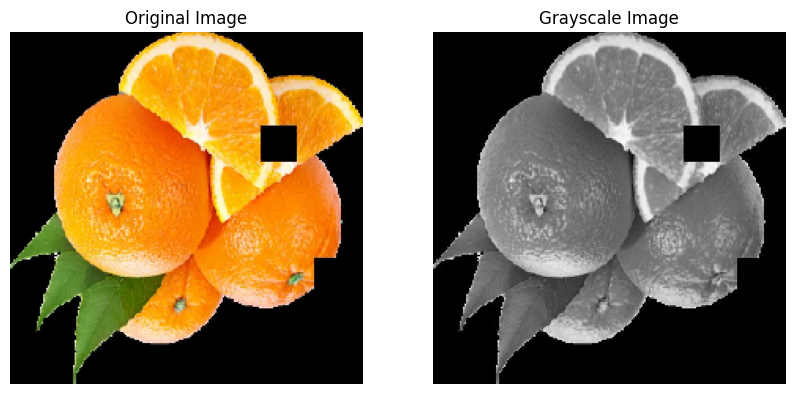

In [ ]:
import matplotlib.pyplot as plt
import random

def visualize_preprocessing(image_path):
    # Load the original image
    original_img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    original_img_array = tf.keras.preprocessing.image.img_to_array(original_img)

    # Preprocess the image to grayscale
    gray_image = cv2.cvtColor(original_img_array, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)

    # Plot the original and preprocessed images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(tf.keras.preprocessing.image.array_to_img(original_img_array))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(tf.keras.preprocessing.image.array_to_img(gray_image))
    axes[1].set_title("Grayscale Image")
    axes[1].axis('off')

    plt.show()

def get_random_image_path(directory):
    all_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_files.append(os.path.join(root, file))
    return random.choice(all_files) if all_files else None

# Example usage
random_image_path = get_random_image_path('/content/dataset/train/')
if random_image_path:
    visualize_preprocessing(random_image_path)
else:
    print("No images found in the directory")


### Visualisasi Data Train dengan gambar asli dan grayscale

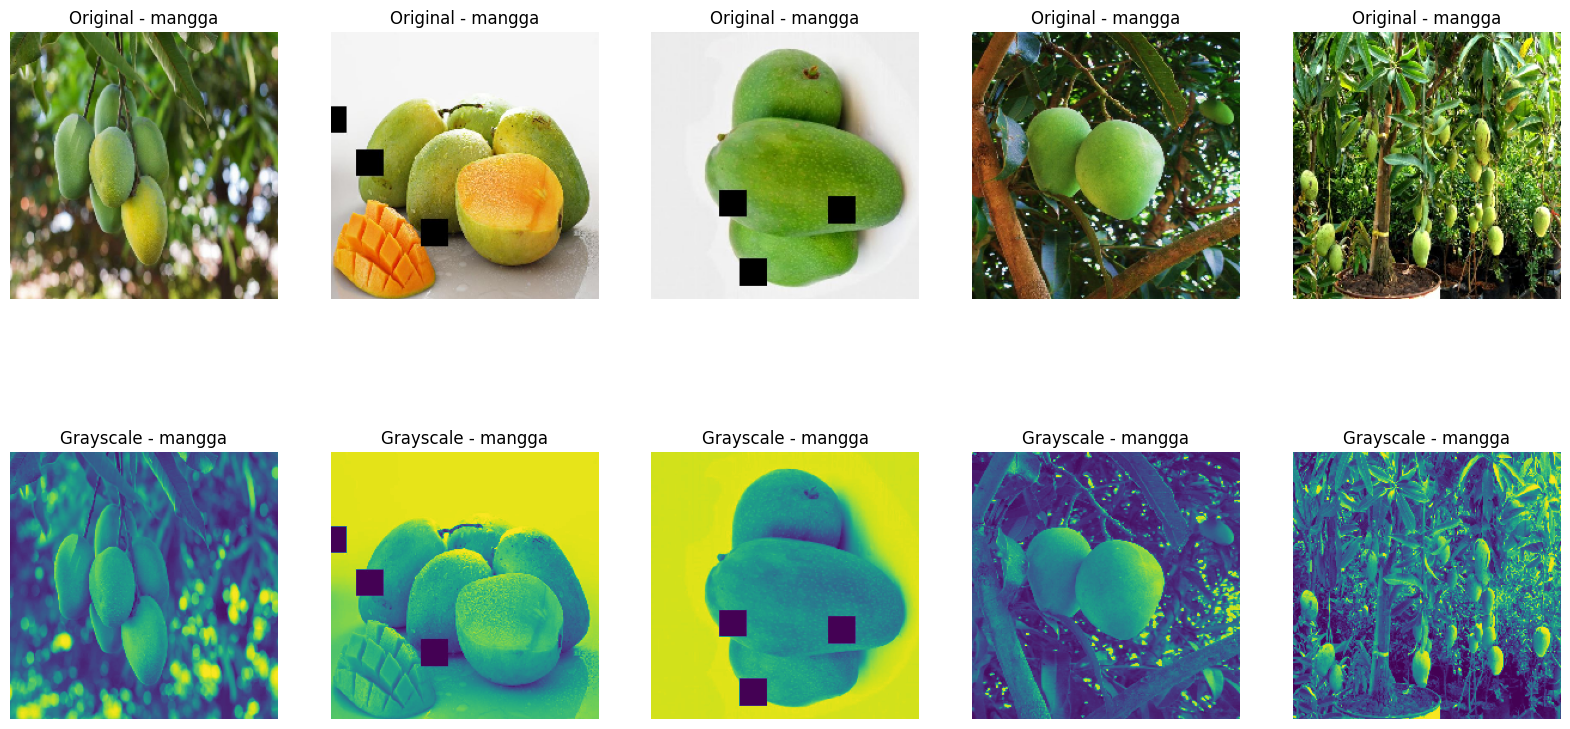

In [ ]:
import matplotlib.pyplot as plt
import random
def load_and_preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    grayscale_img = preprocess_image(img_array)
    return img_array, grayscale_img

def show_images(image_paths, class_names, num_images=5):
    plt.figure(figsize=(20, 10))

    for i in range(num_images):
        image_path = image_paths[i]
        original_img, grayscale_img = load_and_preprocess_image(image_path)

        # Gambar asli
        plt.subplot(2, num_images, i + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(original_img))
        plt.title(f"Original - {class_names[i]}")
        plt.axis('off')

        # Gambar grayscale
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(grayscale_img))
        plt.title(f"Grayscale - {class_names[i]}")
        plt.axis('off')

    plt.show()

def get_random_image_paths_and_classes(directory, num_images=5):
    image_paths = []
    class_names = []

    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            images = os.listdir(class_dir)
            random.shuffle(images)
            selected_images = images[:num_images]
            image_paths.extend([os.path.join(class_dir, img) for img in selected_images])
            class_names.extend([class_name] * num_images)

    return image_paths, class_names

num_images = 5
image_paths, class_names = get_random_image_paths_and_classes(train_dir, num_images)

show_images(image_paths, class_names, num_images)

## Membangun Model

### Arsitektur Model dan Compile Model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),  # Lapisan dengan lebih banyak unit
    layers.BatchNormalization(),  # Menambahkan Batch Normalization
    layers.Dropout(0.5),  # Dropout untuk mengurangi overfitting
    layers.Dense(512, activation='relu'),  # Lapisan tambahan untuk ekstraksi fitur
    layers.BatchNormalization(),  # Batch Normalization lagi
    layers.Dropout(0.3),  # Dropout dengan rate yang berbeda
    layers.Dense(256, activation='relu'),  # Lapisan tambahan untuk ekstraksi fitur
    layers.BatchNormalization(),  # Batch Normalization lagi
    layers.Dropout(0.1),  # Dropout dengan rate yang berbeda
    layers.Dense(train_generator.num_classes, activation='softmax')  # Lapisan output
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 1024)              1311744   
                                                                 
 batch_normalization_12 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                      

### Melatih Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callback untuk menyimpan model terbaik
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True)

num_samples = train_generator.samples
num_epochs = 50  # Jumlah epoch yang ditentukan

# Callback untuk menghentikan pelatihan jika val_accuracy > 91%
early_stopping_cb = EarlyStopping(monitor='val_accuracy',
                                  min_delta=0.005,  # Keakuratan minimum yang dianggap sebagai peningkatan
                                  patience=7,  # Jumlah epoch untuk menunggu sebelum menghentikan
                                  mode='max',
                                  restore_best_weights=True,
                                  verbose=1)

# Callback untuk mengurangi learning rate saat val_loss tidak membaik
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.2,
                                 patience=3,
                                 verbose=1,
                                 min_delta=0.005,
                                 mode='min')

# Melatih model dengan callbacks yang diperbarui
history = model.fit(
    train_generator,
    steps_per_epoch=num_samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=num_epochs,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)


Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 1.4544 - accuracy: 0.5630

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 54s 652ms/step - loss: 1.4544 - accuracy: 0.5630 - val_loss: 2.1369 - val_accuracy: 0.5269 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - 38s 621ms/step - loss: 0.6707 - accuracy: 0.7790 - val_loss: 1.4465 - val_accuracy: 0.6843 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - 41s 660ms/step - loss: 0.4972 - accuracy: 0.8460 - val_loss: 2.2667 - val_accuracy: 0.6401 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - 42s 686ms/step - loss: 0.3785 - accuracy: 0.8786 - val_loss: 1.7765 - val_accuracy: 0.6789 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.8902
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
62/62 [==============================] - 41s 664ms/step - loss: 0.3450 - accuracy: 0.8902 - val_loss: 2.4589 - val_accuracy: 0.6142 - lr: 0.0010
Epoch 6/50
62/62 [==============================] - 42s 688ms/step - lo

### Analisis Akurasi Kelas dengan Confusion Matrix

30/30 [==============================] - 8s 235ms/step


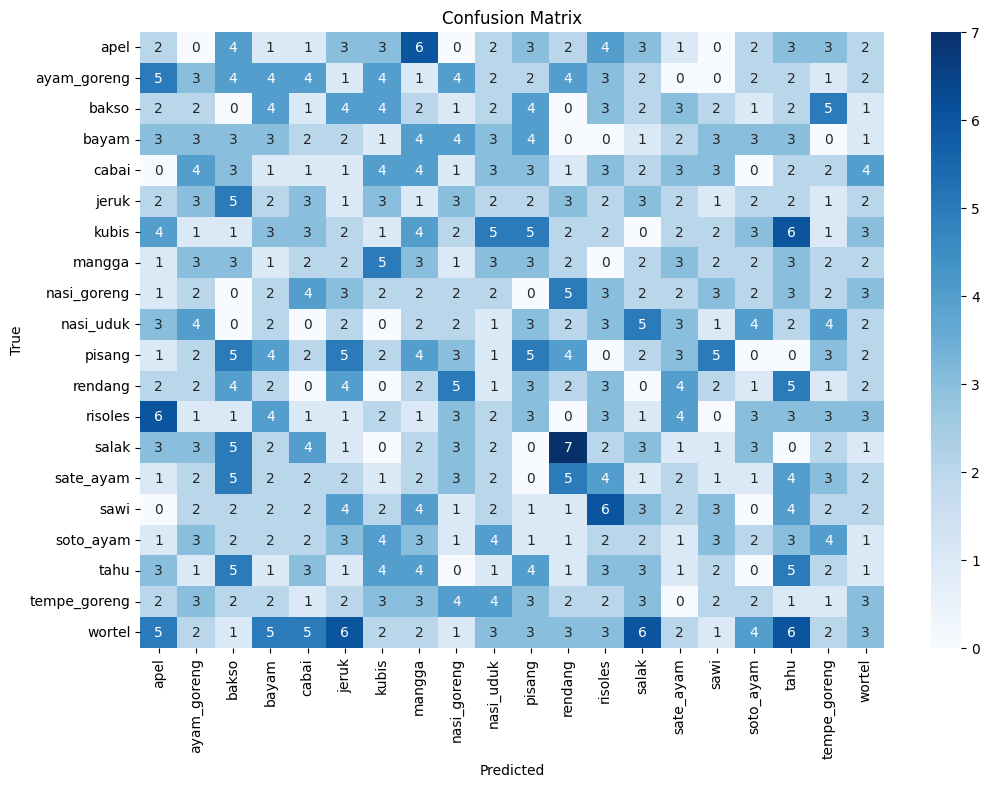

              precision    recall  f1-score   support

        apel       0.04      0.04      0.04        45
 ayam_goreng       0.07      0.06      0.06        50
       bakso       0.00      0.00      0.00        45
       bayam       0.06      0.07      0.06        45
       cabai       0.02      0.02      0.02        45
       jeruk       0.02      0.02      0.02        45
       kubis       0.02      0.02      0.02        52
      mangga       0.05      0.07      0.06        45
 nasi_goreng       0.05      0.04      0.04        45
   nasi_uduk       0.02      0.02      0.02        45
      pisang       0.10      0.09      0.10        53
     rendang       0.04      0.04      0.04        45
     risoles       0.06      0.07      0.06        45
       salak       0.07      0.07      0.07        45
   sate_ayam       0.05      0.04      0.05        45
        sawi       0.08      0.07      0.07        45
   soto_ayam       0.05      0.04      0.05        45
        tahu       0.08    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Membuat prediksi pada data validasi
valid_generator.reset()  # Mengatur ulang generator
y_pred = model.predict(valid_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Mendapatkan kelas prediksi

# Mendapatkan kelas sebenarnya
y_true = valid_generator.classes

# Mendapatkan label kelas
class_labels = list(valid_generator.class_indices.keys())

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


### Grafik Akurasi dan Loss Model

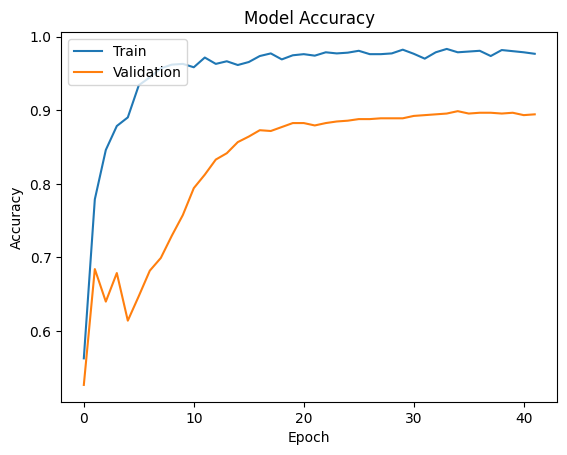

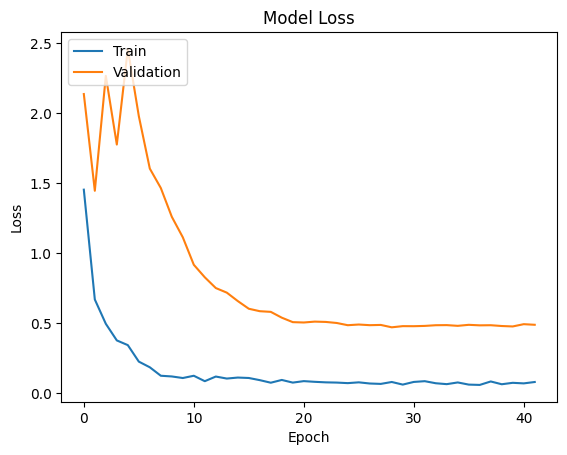

In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi (accuracy)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Implementasi dan Pengujian

Saving ayam goreng.jpg to ayam goreng (1).jpg
Gambar yang diunggah: ayam goreng (1).jpg


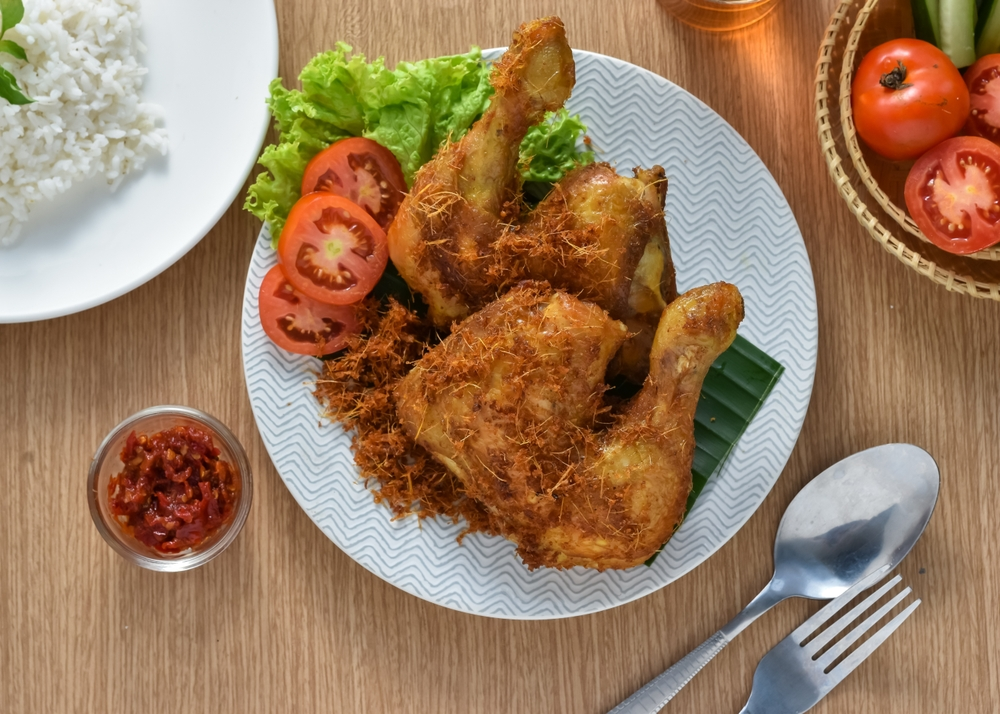

1/1 [==============================] - 1s 834ms/step
Kelas: ayam_goreng, Label: DIREKOMENDASIKAN


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import display, Image
from google.colab import files

# Memuat model terlatih
model = tf.keras.models.load_model("best_model.h5")

# Fungsi untuk mendeteksi kelas dari gambar yang diunggah
def detect_food_class(image_path, model, class_indices):
    img = image.load_img(image_path, target_size=(224, 224))  # Sesuaikan dengan ukuran gambar yang digunakan saat pelatihan
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch

    # Preprocessing gambar
    img_array = img_array / 255.0  # Normalisasi
    predicted_probs = model.predict(img_array)[0]
    predicted_class_index = np.argmax(predicted_probs)
    predicted_class_name = list(class_indices.keys())[predicted_class_index]

    # Memeriksa apakah kelas terdeteksi ada di dataset
    if predicted_class_name in class_indices:
        return predicted_class_name, "DIREKOMENDASIKAN"
    else:
        return predicted_class_name, "TIDAK DIREKOMENDASIKAN"

# Mengunggah file gambar dari komputer
uploaded = files.upload()

# Menampilkan gambar yang diunggah
for filename in uploaded.keys():
    print('Gambar yang diunggah:', filename)
    display(Image(filename))

    # Deteksi kelas dan label
    class_name, label = detect_food_class(filename, model, train_generator.class_indices)
    print(f"Kelas: {class_name}, Label: {label}")


Saving GUNTING.jpg to GUNTING.jpg


1/1 [==============================] - 1s 793ms/step


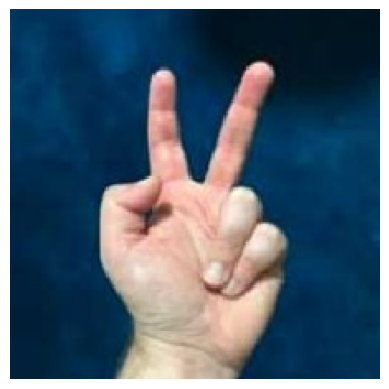

Label: TIDAK DIREKOMENDASIKAN, Confidence: 0.42


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Memuat model terlatih
model = tf.keras.models.load_model("best_model.h5")

# Fungsi untuk mendeteksi kelas dari gambar yang diunggah
def detect_food_class(image_path, model, class_indices):
    img = image.load_img(image_path, target_size=(224, 224))  # Sesuaikan dengan ukuran gambar yang digunakan saat pelatihan
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch

    # Preprocessing gambar
    img_array = img_array / 255.0  # Normalisasi
    predicted_probs = model.predict(img_array)[0]
    predicted_class_index = np.argmax(predicted_probs)
    predicted_class_name = list(class_indices.keys())[predicted_class_index]
    confidence = predicted_probs[predicted_class_index]

    # Memeriksa confidence
    if confidence < 0.5:
        return "TIDAK DIREKOMENDASIKAN", confidence
    else:
        return predicted_class_name, "DIREKOMENDASIKAN", confidence

# Upload gambar dari komputer
uploaded = files.upload()

for filename in uploaded.keys():
    # Mendeteksi kelas gambar dan memberikan label
    result = detect_food_class(filename, model, train_generator.class_indices)

    # Menampilkan gambar
    img = image.load_img(filename, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Menampilkan hasil deteksi
    if len(result) == 2:
        label, confidence = result
        print(f"Label: {label}, Confidence: {confidence:.2f}")
    else:
        class_name, label, confidence = result
        print(f"Class: {class_name}, Label: {label}, Confidence: {confidence:.2f}")

## Deployment

In [ ]:
# 1. Install TensorFlow.js
!pip install tensorflowjs

# 2. Load your Keras model
import tensorflow as tf
model = tf.keras.models.load_model("best_model.h5")

# 3. Save the model in TensorFlow SavedModel format
saved_model_path = "./saved_model"
model.save(saved_model_path)

# 4. Convert the SavedModel to TensorFlow.js format
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model --signature_name=serving_default --saved_model_tags=serve {saved_model_path} ./tfjs_model

# 5. Compress the TensorFlow.js model folder
import shutil
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')

# 6. Download the compressed model
from google.colab import files
files.download('tfjs_model.zip')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
   

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f8cd49631c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f8cd49631c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-06-15 05:07:01.721772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-15 05:07:04.337667: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>